<a href="https://colab.research.google.com/github/harshitaanala/facial-emotion-recognition/blob/main/facial_emotion_recognition_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

Using TensorFlow backend.


In [ ]:
INPUT_PATH = "../input/fer13-cleaned-dataset/"

In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")

print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Angry has 2832 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Happy has 6834 number of images

total images are 16876


In [ ]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Angry images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Happy images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [ ]:
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

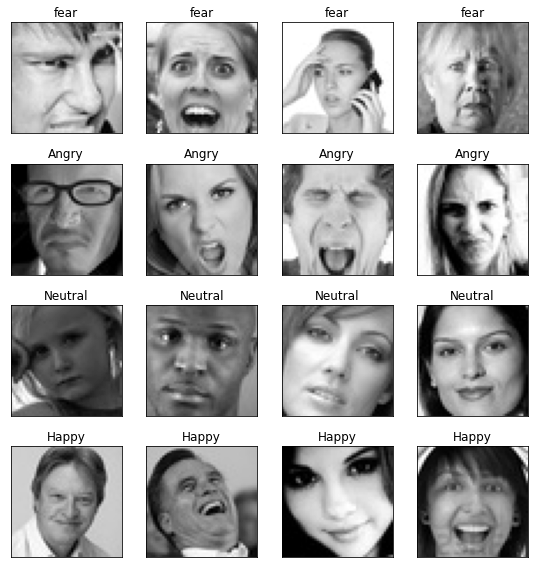

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

(16496, 4)

`Splitting the data into training and validation set.`

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13196, 48, 48, 3), (3300, 48, 48, 3), (13196, 4), (3300, 4))

In [ ]:
del img_arr
del img_label

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# model = Sequential([
#     MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
#     GlobalAveragePooling2D(),
#     Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)),  # Add L2 regularization
#     Dense(num_classes, activation='softmax')
# ])
from keras.regularizers import l2

# Define regularization strength
l2_reg = 0.001  # Example regularization strength, you can adjust as needed

mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
hidden_layer = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(global_pool)
hidden_layer = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(hidden_layer)
out = Dense(num_classes, activation="softmax", name="out_layer")(hidden_layer)

model = Model(inputs=mobile_net.input, outputs=out)

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step


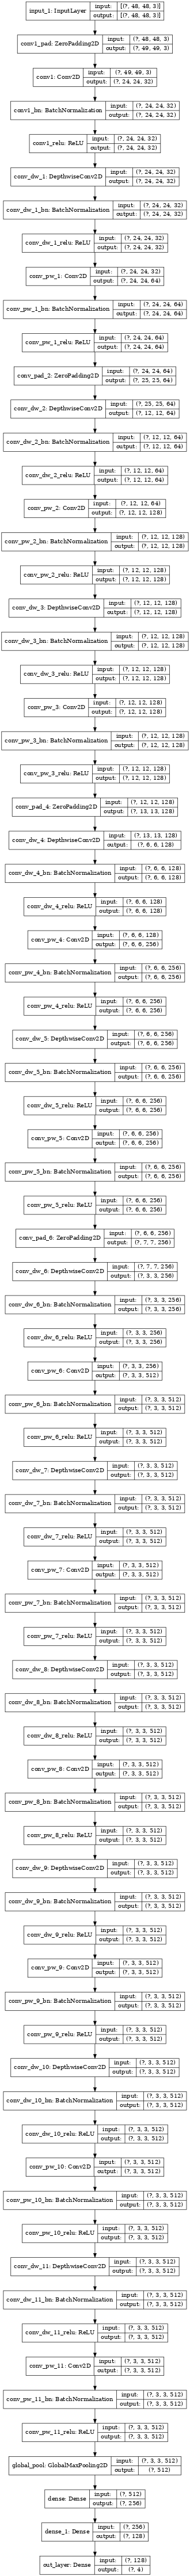

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
     brightness_range=[0.5, 1.5],  # Adjust brightness randomly
     fill_mode='nearest',  # Fill in newly created pixels
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
batch_size = 75
epochs = 30

optims = [
    optimizers.Nadam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)



history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train for 175.94666666666666 steps, validate on 3300 samples
Epoch 1/30
176/175 [==============================] - 19s 106ms/step - loss: 1.9717 - accuracy: 0.4614 - val_loss: 1.3507 - val_accuracy: 0.5245
Epoch 2/30
176/175 [==============================] - 14s 79ms/step - loss: 1.1978 - accuracy: 0.5460 - val_loss: 1.5780 - val_accuracy: 0.4706
Epoch 3/30
176/175 [==============================] - 14s 81ms/step - loss: 1.0864 - accuracy: 0.5575 - val_loss: 1.0459 - val_accuracy: 0.5576
Epoch 4/30
176/175 [==============================] - 14s 80ms/step - loss: 1.0356 - accuracy: 0.5691 - val_loss: 0.9864 - val_accuracy: 0.6015
Epoch 5/30
176/175 [==============================] - 14s 79ms/step - loss: 0.9819 - accuracy: 0.6035 - val_loss: 0.9940 - val_accuracy: 0.6033
Epoch 6/30
176/175 [==============================] - 14s 80ms/step - loss: 0.9585 - accuracy: 0.6141 - val_loss: 1.0162 - val_accuracy: 0.5842
Epoch 7/30
176/175 [==============================] - 14s 81ms/step - loss

In [ ]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

model.save("model_moblenet.h5")

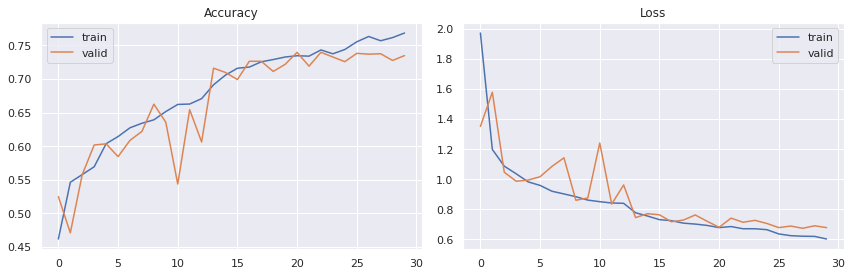

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
label_to_text

{0: 'fear', 1: 'Angry', 2: 'Neutral', 3: 'Happy'}

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'fear': 0, 'Angry': 1, 'Neutral': 2, 'Happy': 3}

test accuracy: 73.4848 %


              precision    recall  f1-score   support

           0       0.62      0.52      0.56       507
           1       0.70      0.46      0.55       567
           2       0.64      0.75      0.69       859
           3       0.84      0.92      0.88      1367

    accuracy                           0.73      3300
   macro avg       0.70      0.66      0.67      3300
weighted avg       0.73      0.73      0.73      3300



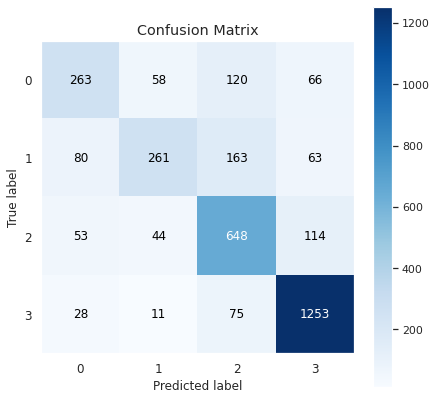

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to `happy`.

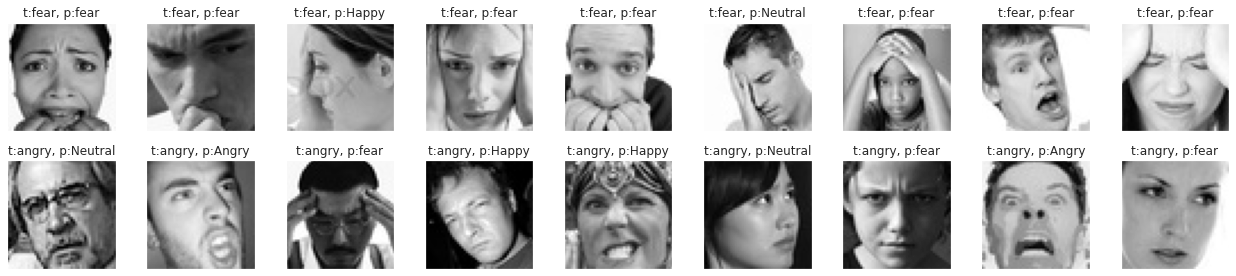

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

One of the reason for such low accuracy is the data quality. Below I have shown all the miss-classified images. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class.

In [ ]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")

total 114 miss labels out of 1367 for emotion Happy


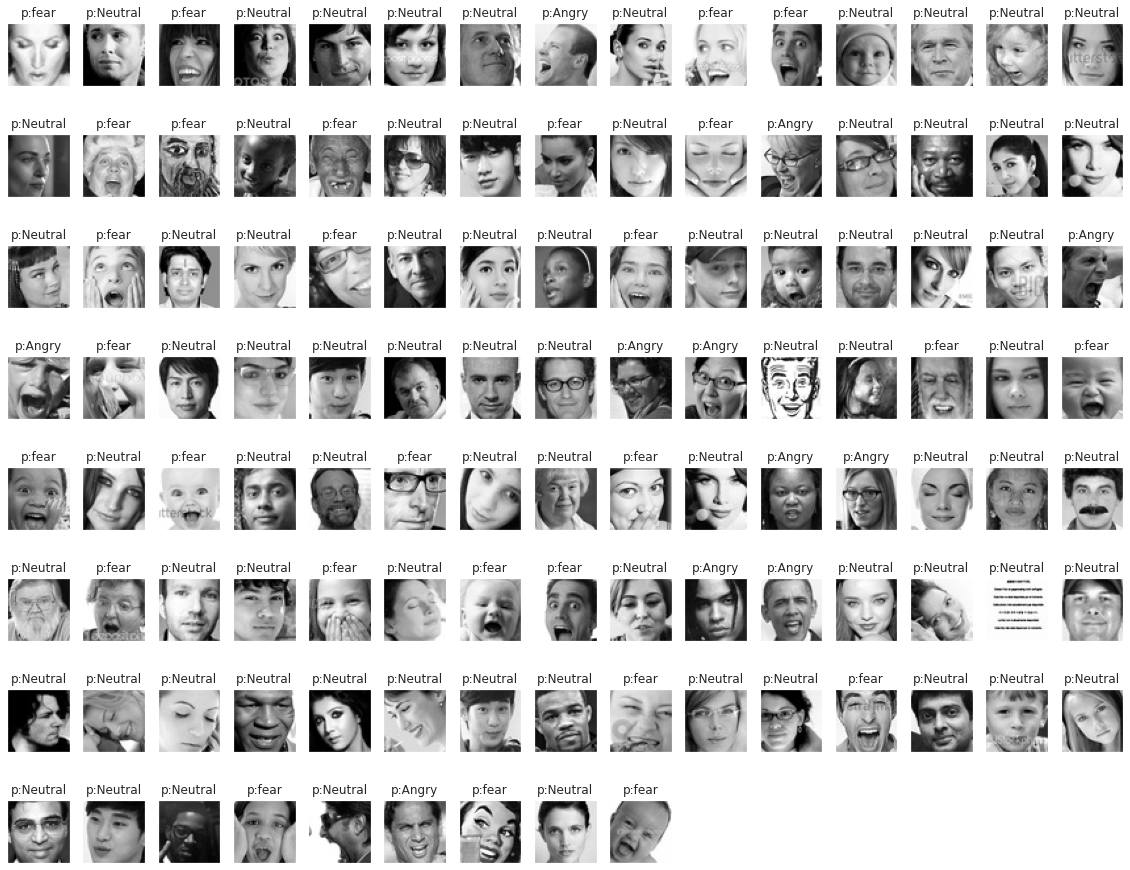

In [ ]:
plot_miss_classified(emotion="Happy")

As we see most of these are classified as `fear` the reason for that is that most of the fear mouths are opened as we see earlier and many of these mouths are opened like that.

total 244 miss labels out of 507 for emotion fear


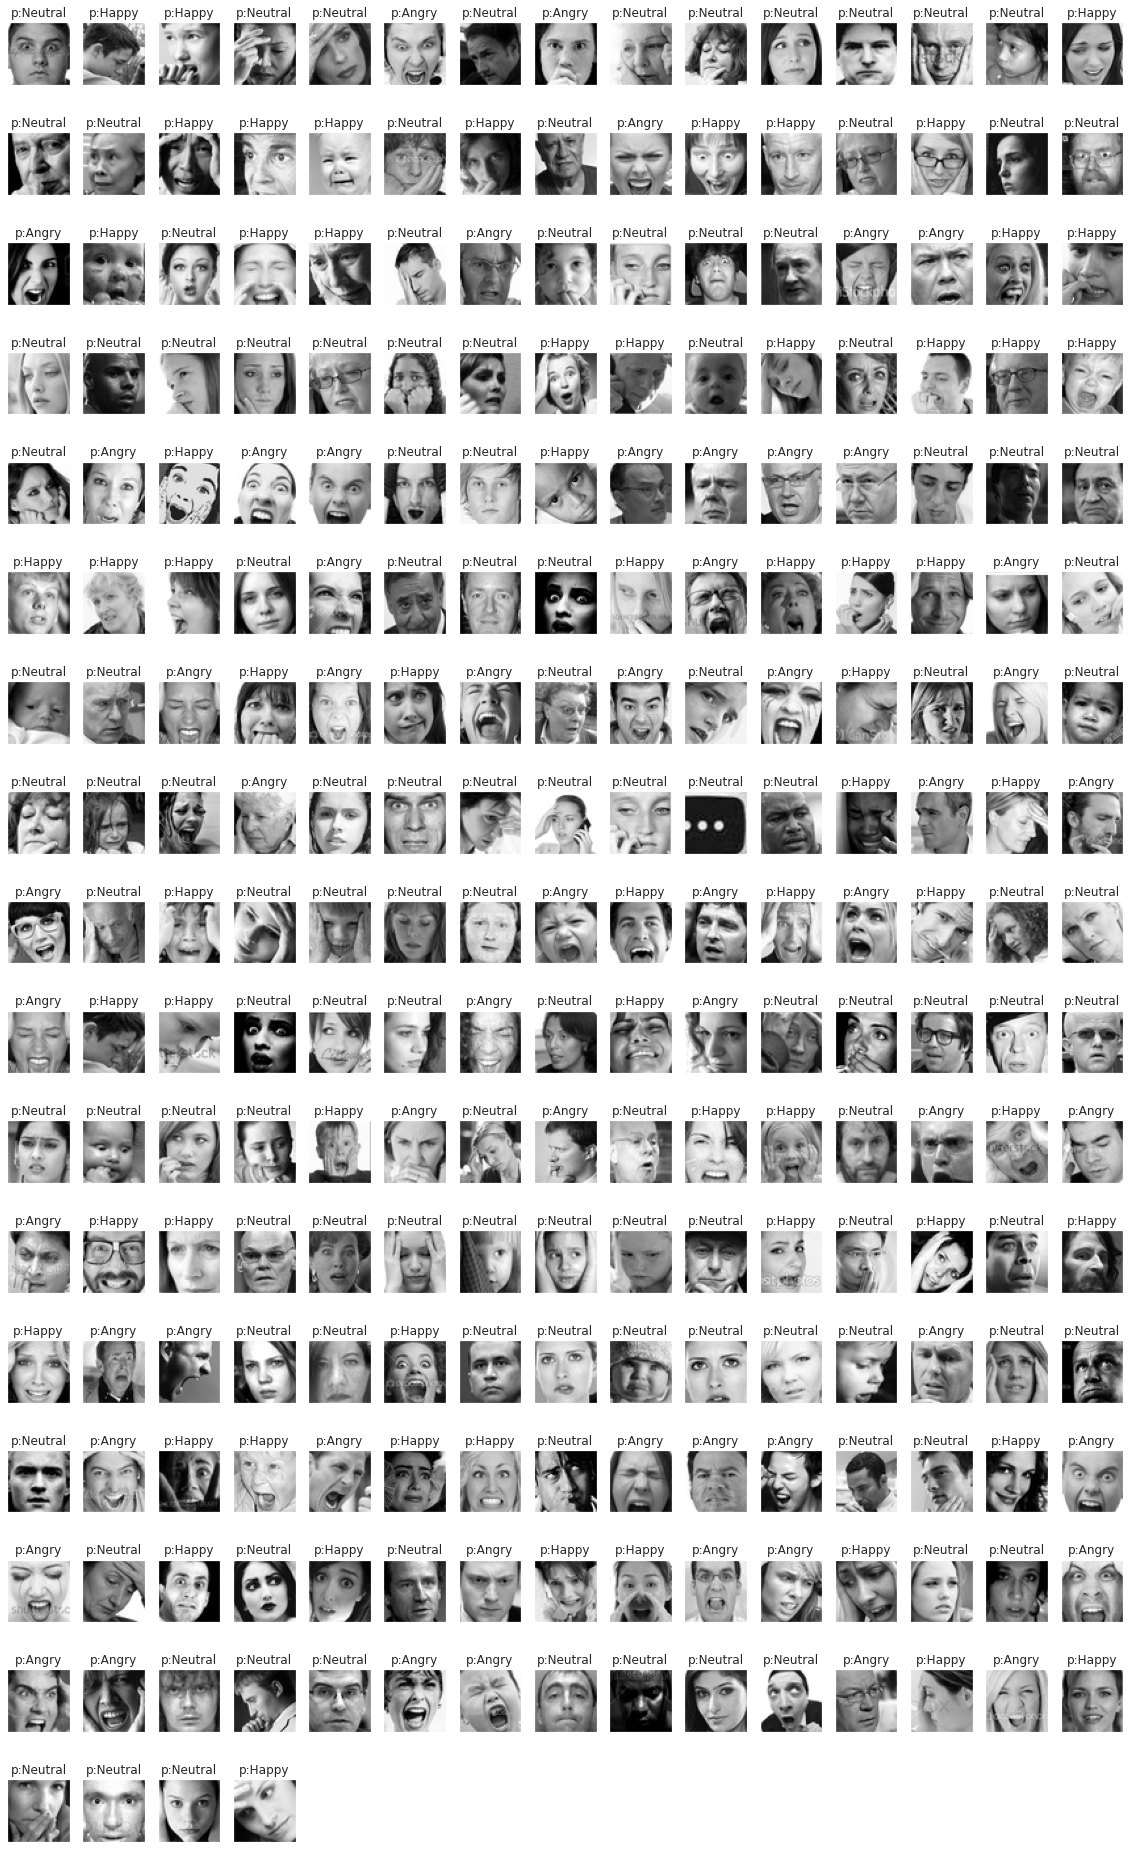

In [ ]:
plot_miss_classified(emotion="fear")

total 306 miss labels out of 567 for emotion Angry


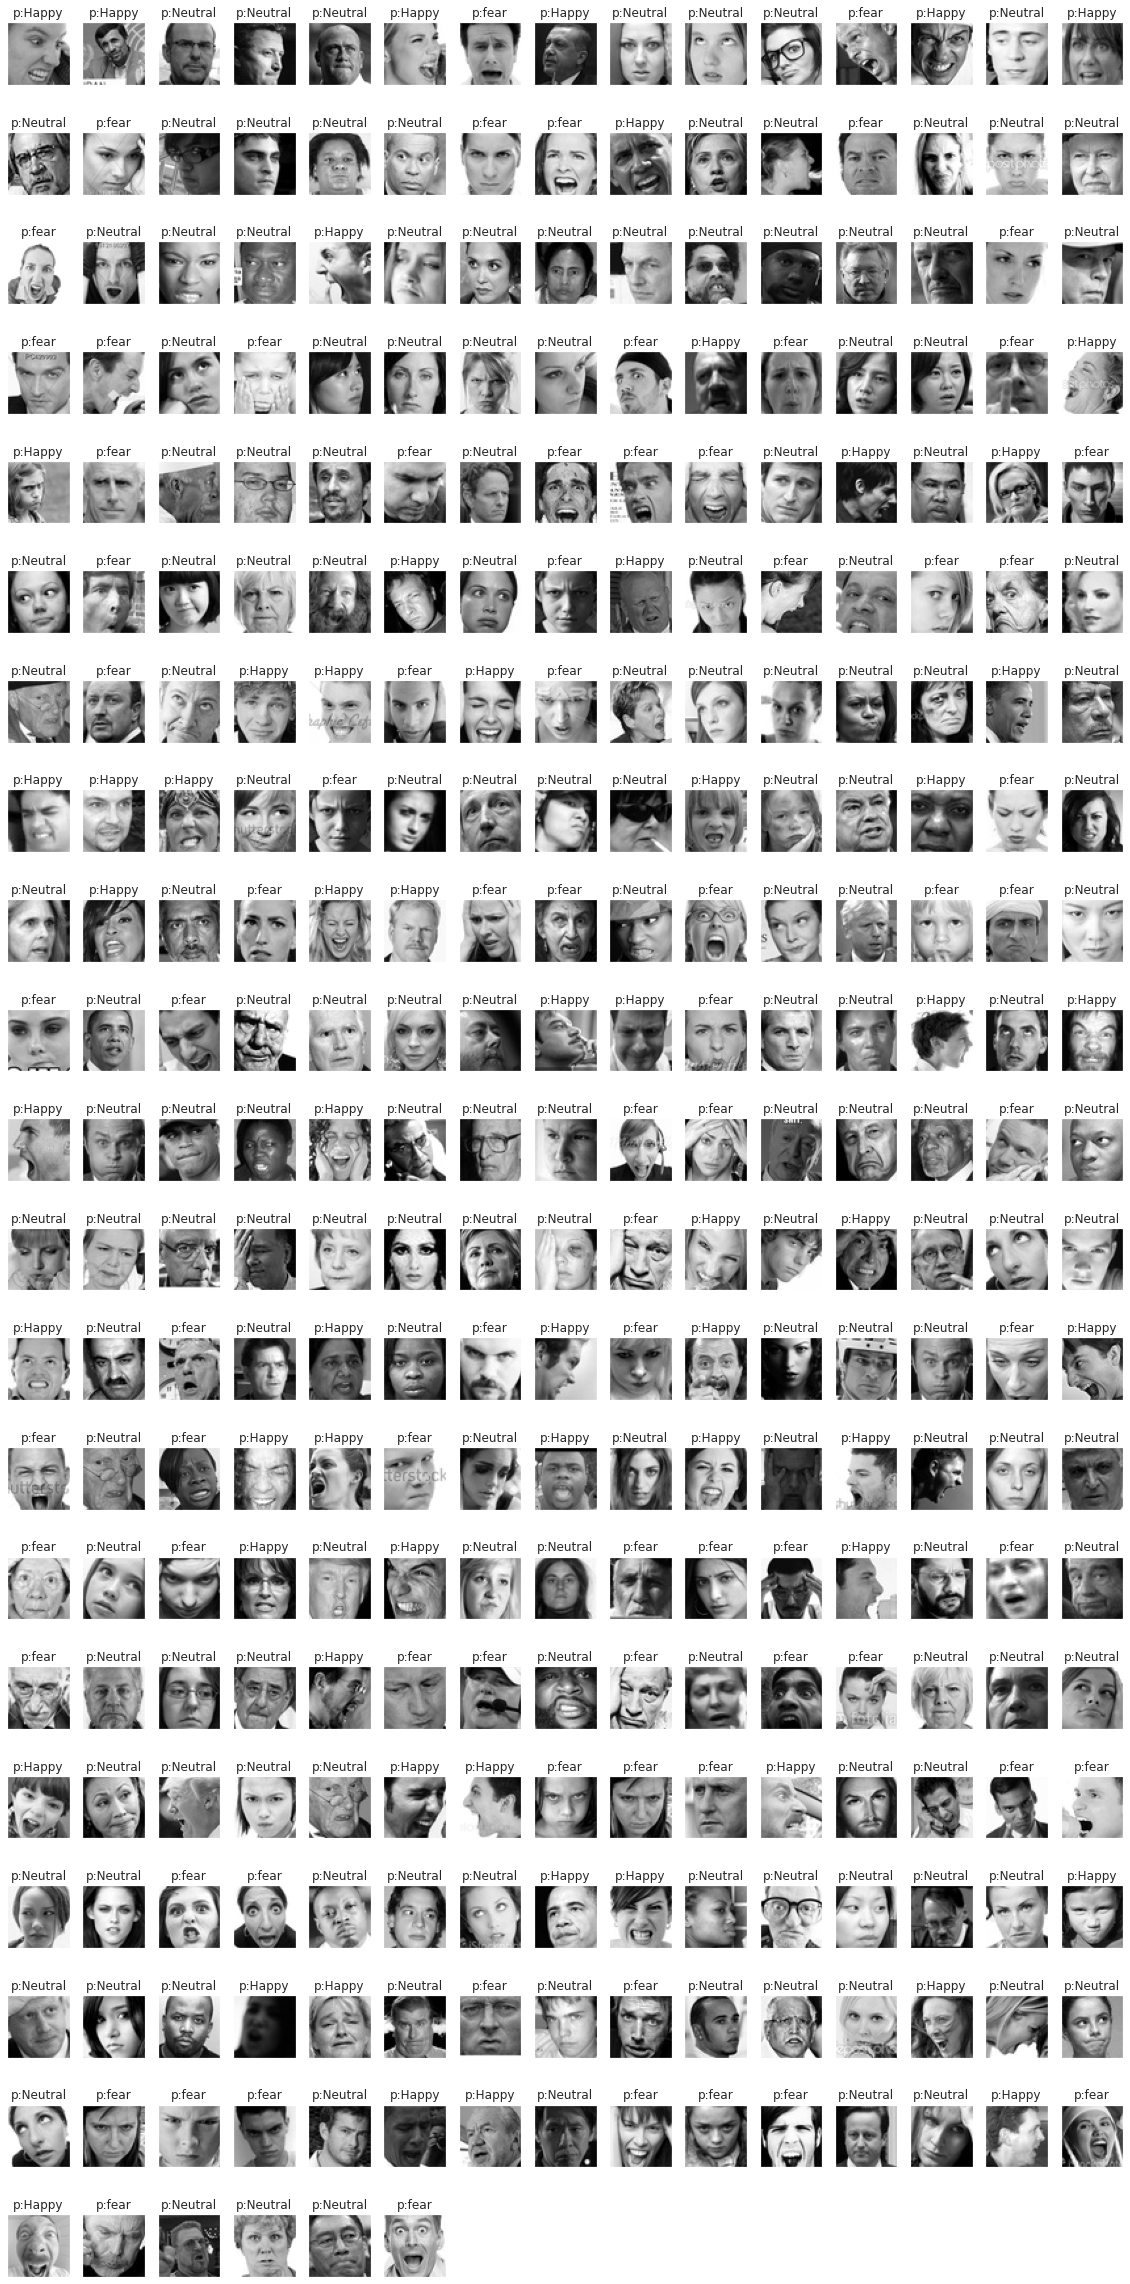

In [ ]:
plot_miss_classified(emotion="Angry")

total 211 miss labels out of 859 for emotion Neutral


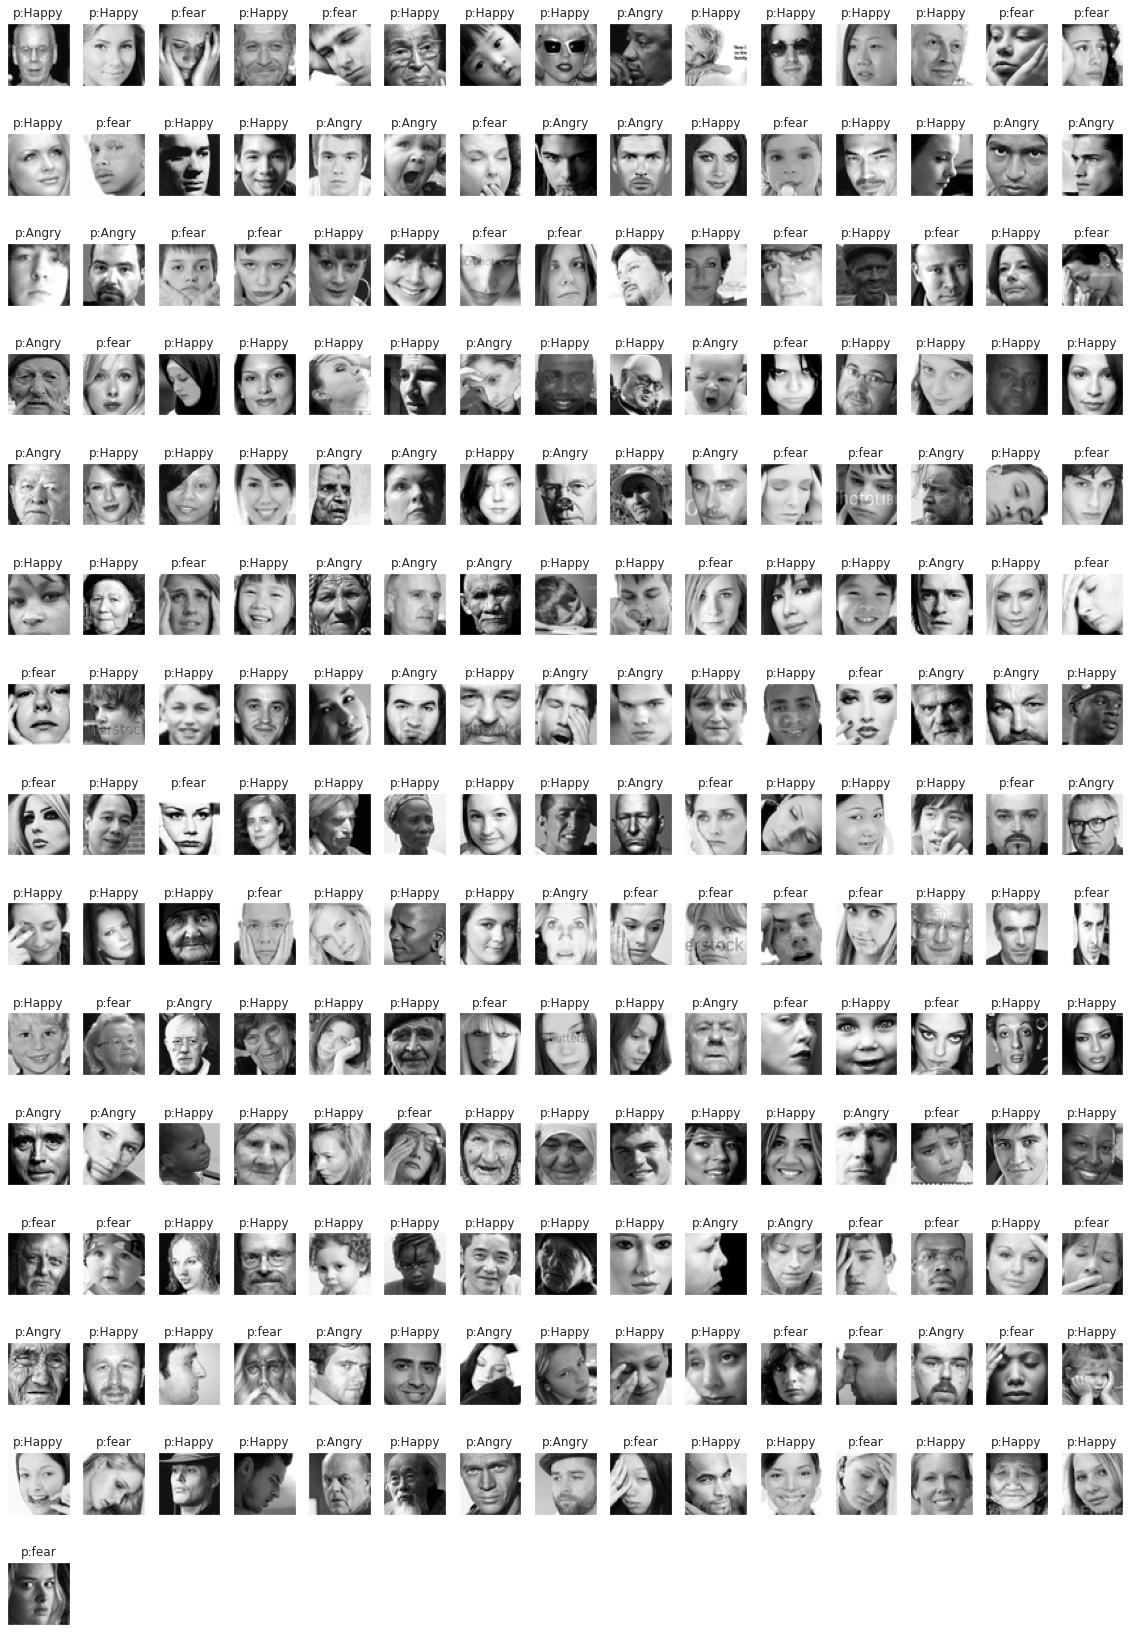

In [ ]:
plot_miss_classified(emotion="Neutral")